D:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


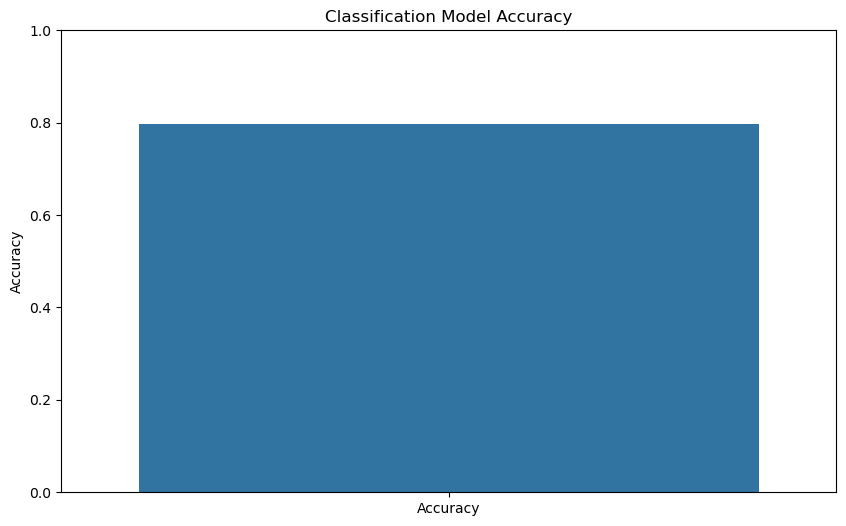

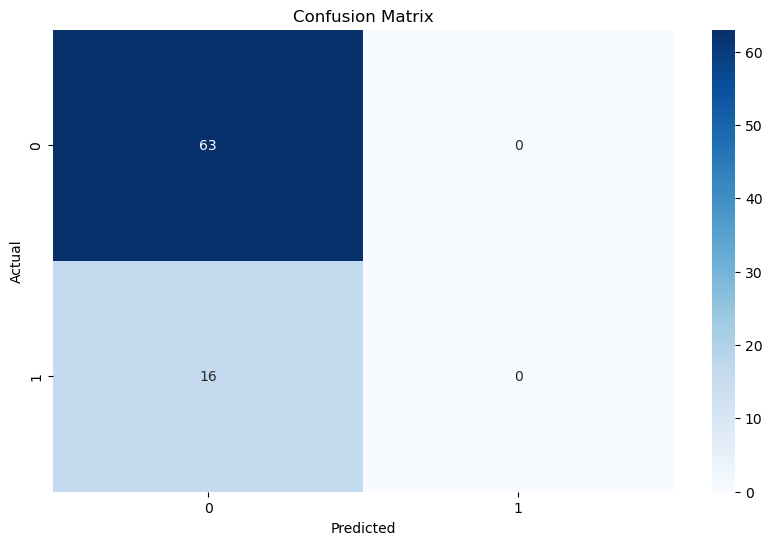

D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
               precision    recall  f1-score   support

         0.0       0.80      1.00      0.89        63
         1.0       0.00      0.00      0.00        16

    accuracy                           0.80        79
   macro avg       0.40      0.50      0.44        79
weighted avg       0.64      0.80      0.71        79



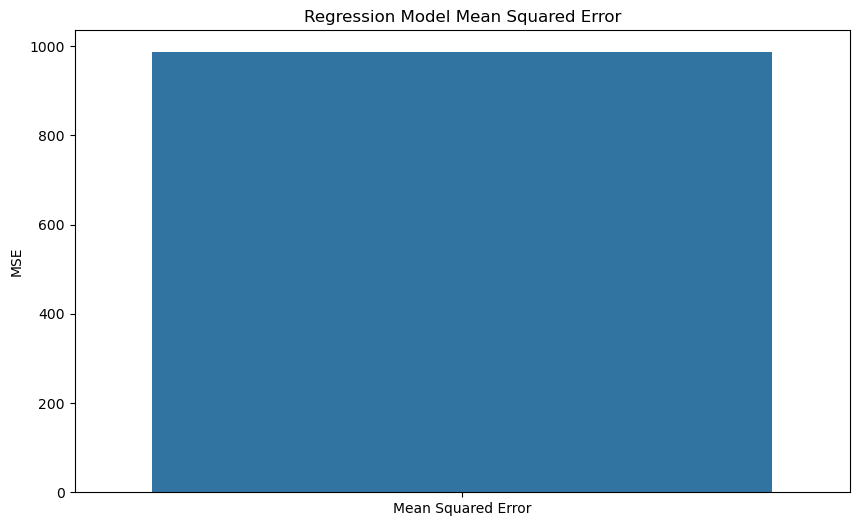

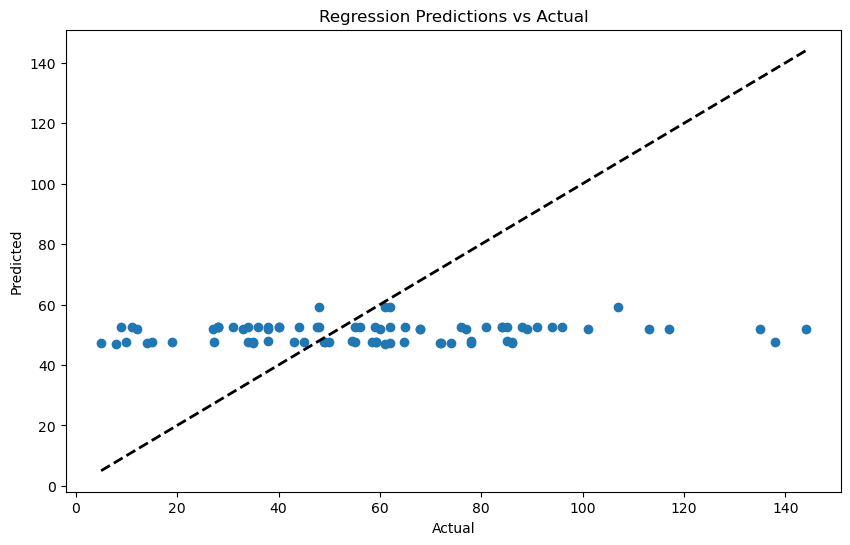

(0.7974683544303798, 986.3353161653403)

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load the dataset
file_path = 'TrainDataset2024.xls'
data = pd.read_excel(file_path)

# Replace '999' with NaN for missing data
data.replace(999, np.nan, inplace=True)

# Remove rows with missing target values
data.dropna(subset=['pCR (outcome)', 'RelapseFreeSurvival (outcome)'], inplace=True)

# Separate features and targets for classification and regression
X = data.drop(columns=['pCR (outcome)', 'RelapseFreeSurvival (outcome)'])
y_classification = data['pCR (outcome)']
y_regression = data['RelapseFreeSurvival (outcome)']

# Retain important features ER, HER2, and Gene
important_features = ['ER', 'HER2', 'Gene']
X_important = X[important_features]

# Impute missing values using KNN
imputer = KNNImputer(n_neighbors=5)
X_important_imputed = imputer.fit_transform(X_important)

# Normalize the important features
scaler = StandardScaler()
X_important_scaled = scaler.fit_transform(X_important_imputed)

# Feature Engineering: Polynomial Features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_important_scaled)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
X_pca = pca.fit_transform(X_poly)

# Split the data into training and testing sets for classification
X_train_classification, X_test_classification, y_train_classification, y_test_classification = train_test_split(
    X_pca, y_classification, test_size=0.2, random_state=42)

# Split the data into training and testing sets for regression
X_train_regression, X_test_regression, y_train_regression, y_test_regression = train_test_split(
    X_pca, y_regression, test_size=0.2, random_state=42)

# Define Neural Network model for classification
classification_model = Sequential()
classification_model.add(Dense(64, input_dim=X_train_classification.shape[1], activation='relu'))
classification_model.add(Dropout(0.5))
classification_model.add(Dense(32, activation='relu'))
classification_model.add(Dropout(0.5))
classification_model.add(Dense(1, activation='sigmoid'))
classification_model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Define Neural Network model for regression
regression_model = Sequential()
regression_model.add(Dense(64, input_dim=X_train_regression.shape[1], activation='relu'))
regression_model.add(Dropout(0.5))
regression_model.add(Dense(32, activation='relu'))
regression_model.add(Dropout(0.5))
regression_model.add(Dense(1))
regression_model.compile(loss='mean_squared_error', optimizer=Adam())

# Train and evaluate the classification model
classification_model.fit(X_train_classification, y_train_classification, epochs=100, batch_size=32, verbose=0)
y_pred_classification_prob = classification_model.predict(X_test_classification)
y_pred_classification = (y_pred_classification_prob > 0.5).astype(int)
classification_accuracy = accuracy_score(y_test_classification, y_pred_classification)

# Train and evaluate the regression model
regression_model.fit(X_train_regression, y_train_regression, epochs=100, batch_size=32, verbose=0)
y_pred_regression = regression_model.predict(X_test_regression)
regression_mse = mean_squared_error(y_test_regression, y_pred_regression)

# Visualizations
# Classification results visualization
plt.figure(figsize=(10, 6))
sns.barplot(x=['Accuracy'], y=[classification_accuracy])
plt.ylim(0, 1)
plt.title('Classification Model Accuracy')
plt.ylabel('Accuracy')
plt.show()

# Confusion matrix for classification
conf_matrix = confusion_matrix(y_test_classification, y_pred_classification)
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Classification report
print("Classification Report:\n", classification_report(y_test_classification, y_pred_classification))

# Regression results visualization
plt.figure(figsize=(10, 6))
sns.barplot(x=['Mean Squared Error'], y=[regression_mse])
plt.title('Regression Model Mean Squared Error')
plt.ylabel('MSE')
plt.show()

# Scatter plot for regression predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test_regression, y_pred_regression)
plt.plot([y_test_regression.min(), y_test_regression.max()], [y_test_regression.min(), y_test_regression.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Regression Predictions vs Actual')
plt.show()

classification_accuracy, regression_mse